In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras import optimizers, losses, activations, models

from tensorflow.keras.initializers import GlorotUniform

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import os

In [24]:
np.exp(-1), np.exp(1), 200 * 0.36

(0.36787944117144233, 2.718281828459045, 72.0)

In [2]:
def get_base_model():
    inp = Input(shape=(500, 64))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = SpatialDropout1D(rate=0.01)(img_1)
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    out = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
#     out = GlobalMaxPool1D()(img_1)


    base_model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(0.001)

    base_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    #model.summary()
    return base_model

In [3]:
def get_model_lstm():
    nclass = 3

    seq_input = Input(shape=(500, 64))
    base_model = get_base_model()
    encoded_sequence = base_model(seq_input)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Flatten()(encoded_sequence)
    out = Dense(nclass, activation="softmax")(encoded_sequence)
#     out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)

    model = models.Model(seq_input, out)

    model.compile(optimizers.Adam(0.001), losses.categorical_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [4]:
def temporal_model_nn():
    
    model = Sequential()
    
    model.add(Dense(1000, input_shape=(500, 64), activation="relu"))
    model.add(Dense(800, activation="relu"))
    model.add(Dense(500, activation="relu"))
    model.add(Flatten())
    model.add(Dense(3, activation="relu"))
    
    model.summary()
    return model

In [5]:
class DataGenerator(Sequence):
    def __init__(self, path, X, Y, target_shape=None, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.path = path
        self.target_shape = target_shape
        self.Y = Y
        self.indices = X
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = self.indices[index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        t_d, ch_d = self.target_shape
        
        X = np.empty((len(batch), t_d, ch_d))
        y = np.empty((len(batch), self.num_classes))
        
        for i, id in enumerate(batch):
            path = os.path.join(self.path, '{}.npy'.format(id))
            X[i,] = np.load(path)
            y[i] = self.Y[id-1]
            
        X = np.swapaxes(X, 1,2)
        return X, y

## RT-50

In [3]:
X_train = np.load("data/X_train.npy")
# X_val = np.load("data/X_val.npy")
X_test = np.load("data/X_test.npy")

Y_train = np.load("data/Y_train.npy")
# Y_val = np.load("data/Y_val.npy")
Y_test = np.load("data/Y_test.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'data/Y_train.npy'

In [5]:
X_train = np.swapaxes(X_train, 1,2)
X_test = np.swapaxes(X_test, 1,2)
X_val = np.swapaxes(X_val, 1,2)

In [6]:
X_train.shape

(37501, 500, 64)

In [7]:
model = temporal_model()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

tb = TensorBoard(log_dir="Tensorboard")
ch = ModelCheckpoint("models/t-vgg_mod_10.h5", monitor='val_accuracy')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 498, 16)           3088      
_________________________________________________________________
batch_normalization (BatchNo (None, 498, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 498, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 16)           784       
_________________________________________________________________
batch_normalization_1 (Batch (None, 496, 16)           64        
_________________________________________________________________
activation_1 (Activation)    (None, 496, 16)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 493, 16)           0

In [8]:
h = model.fit(x=X_train, y=Y_train, epochs=60, validation_data=[X_val, Y_val], callbacks=[tb,ch])

Train on 37501 samples, validate on 17500 samples
Epoch 1/60
37501/37501 [==============================] - 24s 634us/sample - loss: 1.9948 - accuracy: 0.6137 - val_loss: 1.4217 - val_accuracy: 0.7737
Epoch 2/60
37501/37501 [==============================] - 13s 347us/sample - loss: 1.2053 - accuracy: 0.7913 - val_loss: 0.9923 - val_accuracy: 0.8414
Epoch 3/60
37501/37501 [==============================] - 13s 346us/sample - loss: 0.8883 - accuracy: 0.8480 - val_loss: 0.7613 - val_accuracy: 0.8796
Epoch 4/60
37501/37501 [==============================] - 13s 346us/sample - loss: 0.7003 - accuracy: 0.8795 - val_loss: 0.6203 - val_accuracy: 0.8973
Epoch 5/60
37501/37501 [==============================] - 13s 345us/sample - loss: 0.5767 - accuracy: 0.9010 - val_loss: 0.5186 - val_accuracy: 0.9122
Epoch 6/60
37501/37501 [==============================] - 13s 345us/sample - loss: 0.4921 - accuracy: 0.9139 - val_loss: 0.4522 - val_accuracy: 0.9246
Epoch 7/60
37501/37501 [====================

Epoch 52/60
37501/37501 [==============================] - 13s 344us/sample - loss: 0.0711 - accuracy: 0.9890 - val_loss: 0.1056 - val_accuracy: 0.9762
Epoch 53/60
37501/37501 [==============================] - 13s 344us/sample - loss: 0.0700 - accuracy: 0.9890 - val_loss: 0.1194 - val_accuracy: 0.9728
Epoch 54/60
37501/37501 [==============================] - 13s 345us/sample - loss: 0.0740 - accuracy: 0.9872 - val_loss: 0.1037 - val_accuracy: 0.9778
Epoch 55/60
37501/37501 [==============================] - 13s 346us/sample - loss: 0.0680 - accuracy: 0.9898 - val_loss: 0.0985 - val_accuracy: 0.9780
Epoch 56/60
37501/37501 [==============================] - 13s 344us/sample - loss: 0.0718 - accuracy: 0.9885 - val_loss: 0.0965 - val_accuracy: 0.9799
Epoch 57/60
37501/37501 [==============================] - 13s 345us/sample - loss: 0.0676 - accuracy: 0.9900 - val_loss: 0.0997 - val_accuracy: 0.9778
Epoch 58/60
37501/37501 [==============================] - 13s 345us/sample - loss: 0.06

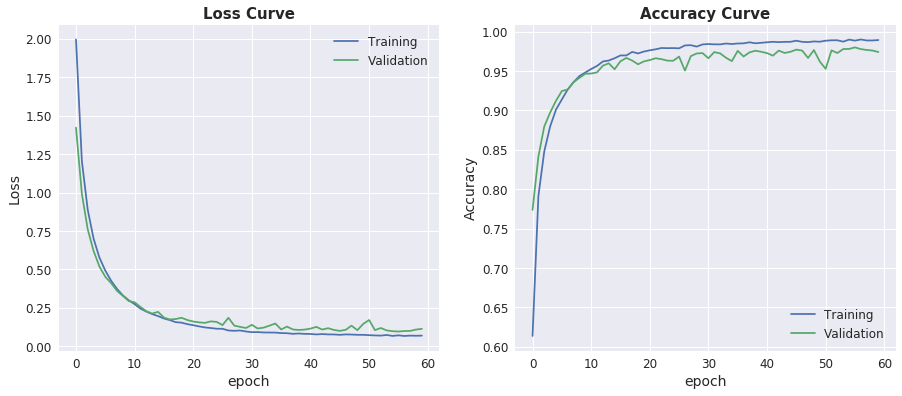

In [14]:
history = h.history
fig, axs = plt.subplots(ncols=2, figsize=(15,6))
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

axs[0].set_title("Loss Curve", fontdict={'size':15, 'weight':'bold'})
axs[0].plot(history['loss'], label='Training')
axs[0].plot(history['val_loss'], label='Validation')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].set_title("Accuracy Curve", fontdict={'size':15, 'weight':'bold'})
axs[1].plot(history['accuracy'], label='Training')
axs[1].plot(history['val_accuracy'], label='Validation')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')

In [10]:
best_model = load_model("models/t-vgg_mod_10.h5")
Y_pred = best_model.predict(X_test)

In [15]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_test= np.argmax(Y_test, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [16]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1534
           1       0.97      0.98      0.97      2956
           2       0.98      0.98      0.98      3034

    accuracy                           0.98      7524
   macro avg       0.98      0.97      0.98      7524
weighted avg       0.98      0.98      0.98      7524



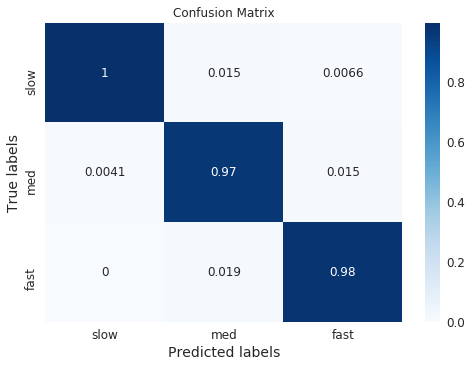

In [17]:
ax = plt.subplot()
sn.heatmap(confusion_matrix(Y_test, Y_pred, normalize='pred'), 
           annot=True, fmt='.2g', cmap=cm.Blues, ax = ax, cbar=True)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['slow', 'med', 'fast']); ax.yaxis.set_ticklabels(['slow', 'med', 'fast']);

## RT-ST

In [5]:
X_train = np.load("data/X_train_st.npy")
X_test = np.load("data/X_test_st.npy")

Y_train = pd.read_csv("data/Y_train_st.csv")
Y_test = pd.read_csv("data/Y_test_st.csv")

In [6]:
X_train = X_train.reshape((-1, 64, 500))
X_test = X_test.reshape((-1, 64, 500))

X_train = np.swapaxes(X_train, 1,2)
X_test = np.swapaxes(X_test, 1,2)

y_train = Y_train['labels'].values
y_test = Y_test['labels'].values


Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [7]:
model = get_model_lstm()

tb = TensorBoard(log_dir="Tensorboard")
ch = ModelCheckpoint("models/t-vgg_mod_st_1.h5", monitor='val_acc', save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, verbose=2, min_lr=1e-7)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 64)]         0         
_________________________________________________________________
model (Model)                (None, 54, 64)            35872     
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 200)           132000    
_________________________________________________________________
dropout (Dropout)            (None, 54, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 54, 200)           240800    
_________________________________________________________________
flatten (Flatten)            (None, 10800)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3240

In [8]:
train_it = DataGenerator(X_train, Y_train, num_classes=3, batch_size=256)

test_it = DataGenerator(X_test, Y_test, num_classes=3, batch_size=256)

In [9]:
h = model.fit_generator(train_it, epochs=500, validation_data=test_it, callbacks=[tb,ch, redonplat])

Epoch 1/500
133/133 [==============================] - 25s 188ms/step - loss: 0.8341 - acc: 0.6656 - val_loss: 0.7962 - val_acc: 0.6757
Epoch 2/500
133/133 [==============================] - 24s 179ms/step - loss: 0.7917 - acc: 0.6692 - val_loss: 0.7669 - val_acc: 0.6808
Epoch 3/500
133/133 [==============================] - 24s 179ms/step - loss: 0.7669 - acc: 0.6802 - val_loss: 0.7668 - val_acc: 0.6813
Epoch 4/500
133/133 [==============================] - 24s 180ms/step - loss: 0.7551 - acc: 0.6853 - val_loss: 0.7445 - val_acc: 0.6914
Epoch 5/500
133/133 [==============================] - 24s 179ms/step - loss: 0.7446 - acc: 0.6906 - val_loss: 0.7612 - val_acc: 0.6824
Epoch 6/500
133/133 [==============================] - 24s 179ms/step - loss: 0.7410 - acc: 0.6916 - val_loss: 0.7331 - val_acc: 0.6952
Epoch 7/500
133/133 [==============================] - 24s 178ms/step - loss: 0.7284 - acc: 0.6973 - val_loss: 0.7389 - val_acc: 0.6955
Epoch 8/500
133/133 [===========================

Epoch 55/500
133/133 [==============================] - 24s 184ms/step - loss: 0.5265 - acc: 0.7845 - val_loss: 0.7887 - val_acc: 0.6974
Epoch 56/500
133/133 [==============================] - 24s 182ms/step - loss: 0.5265 - acc: 0.7841 - val_loss: 0.7894 - val_acc: 0.6971
Epoch 57/500
133/133 [==============================] - 24s 182ms/step - loss: 0.5245 - acc: 0.7850 - val_loss: 0.7898 - val_acc: 0.6966
Epoch 58/500
133/133 [==============================] - 24s 183ms/step - loss: 0.5248 - acc: 0.7853 - val_loss: 0.7891 - val_acc: 0.6965
Epoch 59/500
132/133 [============================>.] - ETA: 0s - loss: 0.5249 - acc: 0.7872
Epoch 00059: ReduceLROnPlateau reducing learning rate to 1e-07.
133/133 [==============================] - 24s 183ms/step - loss: 0.5252 - acc: 0.7870 - val_loss: 0.7919 - val_acc: 0.6962
Epoch 60/500
133/133 [==============================] - 24s 183ms/step - loss: 0.5265 - acc: 0.7845 - val_loss: 0.7895 - val_acc: 0.6971
Epoch 61/500
133/133 [============

Epoch 105/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5238 - acc: 0.7882 - val_loss: 0.7907 - val_acc: 0.6964
Epoch 106/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5248 - acc: 0.7850 - val_loss: 0.7899 - val_acc: 0.6965
Epoch 107/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5253 - acc: 0.7852 - val_loss: 0.7904 - val_acc: 0.6966
Epoch 108/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5262 - acc: 0.7833 - val_loss: 0.7901 - val_acc: 0.6968
Epoch 109/500
132/133 [============================>.] - ETA: 0s - loss: 0.5257 - acc: 0.7846
Epoch 00109: ReduceLROnPlateau reducing learning rate to 1e-07.
133/133 [==============================] - 24s 181ms/step - loss: 0.5259 - acc: 0.7845 - val_loss: 0.7880 - val_acc: 0.6975
Epoch 110/500
133/133 [==============================] - 24s 179ms/step - loss: 0.5263 - acc: 0.7877 - val_loss: 0.7892 - val_acc: 0.6979
Epoch 111/500
133/133 [=====

Epoch 155/500
133/133 [==============================] - 24s 179ms/step - loss: 0.5239 - acc: 0.7874 - val_loss: 0.7912 - val_acc: 0.6965
Epoch 156/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5267 - acc: 0.7850 - val_loss: 0.7907 - val_acc: 0.6962
Epoch 157/500
133/133 [==============================] - 24s 179ms/step - loss: 0.5267 - acc: 0.7851 - val_loss: 0.7903 - val_acc: 0.6968
Epoch 158/500
133/133 [==============================] - 24s 179ms/step - loss: 0.5249 - acc: 0.7861 - val_loss: 0.7925 - val_acc: 0.6959
Epoch 159/500
132/133 [============================>.] - ETA: 0s - loss: 0.5249 - acc: 0.7844
Epoch 00159: ReduceLROnPlateau reducing learning rate to 1e-07.
133/133 [==============================] - 24s 178ms/step - loss: 0.5250 - acc: 0.7842 - val_loss: 0.7904 - val_acc: 0.6965
Epoch 160/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5232 - acc: 0.7856 - val_loss: 0.7911 - val_acc: 0.6969
Epoch 161/500
133/133 [=====

Epoch 205/500
133/133 [==============================] - 24s 182ms/step - loss: 0.5257 - acc: 0.7856 - val_loss: 0.7920 - val_acc: 0.6956
Epoch 206/500
133/133 [==============================] - 24s 182ms/step - loss: 0.5252 - acc: 0.7843 - val_loss: 0.7907 - val_acc: 0.6963
Epoch 207/500
133/133 [==============================] - 24s 181ms/step - loss: 0.5252 - acc: 0.7854 - val_loss: 0.7935 - val_acc: 0.6952
Epoch 208/500
133/133 [==============================] - 24s 183ms/step - loss: 0.5245 - acc: 0.7849 - val_loss: 0.7905 - val_acc: 0.6962
Epoch 209/500
132/133 [============================>.] - ETA: 0s - loss: 0.5243 - acc: 0.7854
Epoch 00209: ReduceLROnPlateau reducing learning rate to 1e-07.
133/133 [==============================] - 24s 181ms/step - loss: 0.5242 - acc: 0.7853 - val_loss: 0.7909 - val_acc: 0.6962
Epoch 210/500
133/133 [==============================] - 24s 181ms/step - loss: 0.5236 - acc: 0.7842 - val_loss: 0.7908 - val_acc: 0.6962
Epoch 211/500
133/133 [=====

Epoch 255/500
133/133 [==============================] - 24s 182ms/step - loss: 0.5264 - acc: 0.7827 - val_loss: 0.7915 - val_acc: 0.6961
Epoch 256/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5262 - acc: 0.7852 - val_loss: 0.7921 - val_acc: 0.6965
Epoch 257/500
133/133 [==============================] - 24s 180ms/step - loss: 0.5233 - acc: 0.7859 - val_loss: 0.7906 - val_acc: 0.6966
Epoch 258/500
133/133 [==============================] - 24s 179ms/step - loss: 0.5245 - acc: 0.7852 - val_loss: 0.7905 - val_acc: 0.6965
Epoch 259/500
132/133 [============================>.] - ETA: 0s - loss: 0.5257 - acc: 0.7868
Epoch 00259: ReduceLROnPlateau reducing learning rate to 1e-07.
133/133 [==============================] - 24s 181ms/step - loss: 0.5256 - acc: 0.7868 - val_loss: 0.7901 - val_acc: 0.6968
Epoch 260/500
133/133 [==============================] - 24s 181ms/step - loss: 0.5255 - acc: 0.7838 - val_loss: 0.7916 - val_acc: 0.6958
Epoch 261/500
133/133 [=====

KeyboardInterrupt: 

## RT - 20

In [6]:
X_train = pd.read_csv("data/X_train_10.csv", header=None)
X_test = pd.read_csv("data/X_test_10.csv", header=None)

Y = np.load("data/Y_RT_10.npy")
Y = to_categorical(Y)


In [7]:
X_train = X_train.values.flatten()
X_test = X_test.values.flatten()

In [8]:
X_train.shape

(22201,)

In [9]:
train_it = DataGenerator('data/RT_10_data', X_train, Y, (64, 500), num_classes=3, batch_size=256)

test_it = DataGenerator('data/RT_10_data', X_test, Y, (64, 500), num_classes=3, batch_size=256)

In [10]:
model = get_model_lstm()

tb = TensorBoard(log_dir="Tensorboard")
ch = ModelCheckpoint("models/t-vgg_mod_rt_10_2.h5", monitor='val_acc', save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, verbose=2, min_lr=1e-7)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 64)]         0         
_________________________________________________________________
model (Model)                (None, 54, 64)            35872     
_________________________________________________________________
bidirectional (Bidirectional (None, 54, 200)           132000    
_________________________________________________________________
dropout (Dropout)            (None, 54, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 54, 200)           240800    
_________________________________________________________________
flatten (Flatten)            (None, 10800)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3240

In [11]:
h = model.fit_generator(train_it, epochs=100, validation_data=test_it, callbacks=[tb,ch, redonplat], 
                        use_multiprocessing=True)

Epoch 1/100
86/86 [==============================] - 23s 268ms/step - loss: 1.0391 - acc: 0.4577 - val_loss: 0.9466 - val_acc: 0.5509
Epoch 2/100
86/86 [==============================] - 22s 250ms/step - loss: 0.9220 - acc: 0.5651 - val_loss: 0.8869 - val_acc: 0.5903
Epoch 3/100
86/86 [==============================] - 21s 249ms/step - loss: 0.8594 - acc: 0.6097 - val_loss: 0.8406 - val_acc: 0.6246
Epoch 4/100
86/86 [==============================] - 22s 258ms/step - loss: 0.8137 - acc: 0.6332 - val_loss: 0.8222 - val_acc: 0.6339
Epoch 5/100
86/86 [==============================] - 22s 251ms/step - loss: 0.7864 - acc: 0.6519 - val_loss: 0.7838 - val_acc: 0.6579
Epoch 6/100
86/86 [==============================] - 21s 249ms/step - loss: 0.7552 - acc: 0.6669 - val_loss: 0.7878 - val_acc: 0.6540
Epoch 7/100
86/86 [==============================] - 22s 251ms/step - loss: 0.7219 - acc: 0.6872 - val_loss: 0.7390 - val_acc: 0.6789
Epoch 8/100
86/86 [==============================] - 22s 256ms